# MiBiReMo Example 1: Calcite Titration Curve

This notebook uses MiBiReMo to simulate the following reaction:

$$\mathrm{CaCO_3(s) + 2HCl(aq) \rightarrow CaCl_2(aq) + CO_2(g) + H_2O(l)}$$

An initial amount of calcite is titrated with hydrochloric acid (HCl) in a closed system. The system is initially at equilibrium, and the titration is performed by adding HCl in small increments. The resulting changes in the concentrations of the species involved are monitored.
Chemical reactions within each step are assumed to be istantaneous (i.e., equilibrium assumption).

Author: Matteo Masi  
Last revision: 17/02/2026

### Import libraries

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import mibiremo
from importlib.resources import files

### Global settings

In this section, the main parameters for the simulation are defined, including the initial conditions, reaction parameters, and simulation options.

In [2]:
# Global settings
database_path = str(files("mibiremo").joinpath("database/phreeqc.dat"))  # .dat database path
n_cells = 1000  # Number of model cells
n_threads = 4  # Multithread calculation (-1 for all CPUs)
pqi_file = "pqi/ex1_Calcite_titration.pqi"  # Phreeqc input file
hcl_range = [0.0, 4.0]  # mol/L

# Unit settings
unit_solution = 2  # 1: mg/L; 2: mol/L; 3: kg/kgs
units = 1  # 0: mol/L cell; 1: mol/L water; 2: mol/L rock

# Physical properties
porosity = 1.0  # Porosity
saturation = 1.0  # Saturation

### Initialize PhreeqcRM and run initial setup

Here we initialize the PhreeqcRM object and we run an initial simulation to retrieve information about the components and species involved in the simulation. This step is needed to ensure that the system is initialized correctly before proceeding with the titration simulation. After this step, we can get the list of the components and species in the system.

In [3]:
# Initialize PhreeqcRM
phr = mibiremo.PhreeqcRM()
phr.create(nxyz=n_cells, n_threads=n_threads)
phr.initialize_phreeqc(database_path, unit_solution, units, porosity, saturation)

# Prepare the initial conditions
# Use SOLUTION 1 and EQUILIBRIUM_PHASES 1, disable all other model features (-1)
ic = [1, 1, -1, -1, -1, -1, -1]

# Repeat for all other cells (row-wise)
ic = np.tile(ic, (n_cells, 1))

phr.run_initial_from_file(pqi_file, ic)

# Show components and species
print("Components:")
for comp in phr.components:
    print(f"  {comp}")
print("\nSpecies:")
for spec in phr.species:
    print(f"  {spec}")

Components:
  H
  O
  Charge
  C
  Ca
  Cl
  Na

Species:
  (CO2)2
  CH4
  CO2
  CO3-2
  Ca+2
  CaCO3
  CaHCO3+
  CaOH+
  Cl-
  H+
  H2
  H2O
  HCO3-
  Na+
  NaCO3-
  NaHCO3
  NaOH
  O2
  OH-


### Prepare concentration vectors and apply HCl titration

Now we prepare the concentration vectors for the titration simulation. We define first transfer the initial concentrations (from the initial setup) to the concentration vectors, and then we apply the titration by adding HCl in small increments.

In [4]:
# Get components and species
components = phr.components
species = phr.species
n_comps = len(phr.components)
n_species = len(phr.species)


# Initialize concentration vectors
cc = np.zeros(n_cells * n_comps, dtype=np.float64)
cs = np.zeros(n_cells * n_species, dtype=np.float64)
phr.rm_get_concentrations(cc)
phr.rm_get_species_concentrations(cs)

# HCl concentration vector
hcl = np.linspace(hcl_range[0], hcl_range[1], n_cells)  # mol/L

# Find indices for Cl- and H+ species
indx_cl = np.where(species == "Cl-")[0][0]
indx_h = np.where(species == "H+")[0][0]

# Add HCl
cs_r = cs.reshape(n_species, n_cells).T
cs_r[:, indx_cl] += hcl  # Cl-
cs_r[:, indx_h] += hcl  # H+
cs1 = cs_r.T.reshape(n_cells * n_species)  # Updated concentrations (after adding HCl)

### Run simulation with added HCl

The modified concentration vectors are then passed back to the PhreeqcRM object, and the simulation is run.

In [5]:
# Tranfer the modified species concentrations back to PhreeqcRM
phr.rm_species_concentrations2_module(cs1)
phr.rm_set_time(1.0)
phr.rm_set_time_step(1.0)

# Run the simulation
start_time = time.time()
phr.rm_run_cells()
elapsed = time.time() - start_time
print(f"Simulation completed in {elapsed:.2f} seconds")

Simulation completed in 0.05 seconds


### Retrieve and plot the results

The "Selected Output" function of PhreeqcRM is used to retrieve the results of the simulation. A Pandas DataFrame is created to store the results.

In [6]:
# Get the results as a Pandas Dataframe from selected output
results_df = phr.get_selected_output_df()
results_df.head()

,sim,state,soln,dist_x,time,step,pH,pe,mass_H2O,charge(eq),m_H+(mol/kgw),m_OH-(mol/kgw)
0,1.0,1.000000e+30,0.0,-99.0,0.0,1.0,8.336471,12.285796,0.996169,7.635922e-07,5.407556e-09,2.710906e-06
1,1.0,1.000000e+30,1.0,-99.0,0.0,1.0,8.068483,12.553804,0.996210,7.635922e-07,1.006773e-08,1.474132e-06
2,1.0,1.000000e+30,2.0,-99.0,0.0,1.0,7.945004,12.677304,0.996248,7.635922e-07,1.344095e-08,1.118586e-06
3,1.0,1.000000e+30,3.0,-99.0,0.0,1.0,7.868328,12.754002,0.996284,7.635922e-07,1.610660e-08,9.450340e-07
4,1.0,1.000000e+30,4.0,-99.0,0.0,1.0,7.813487,12.808864,0.996321,7.635922e-07,1.834886e-08,8.392179e-07


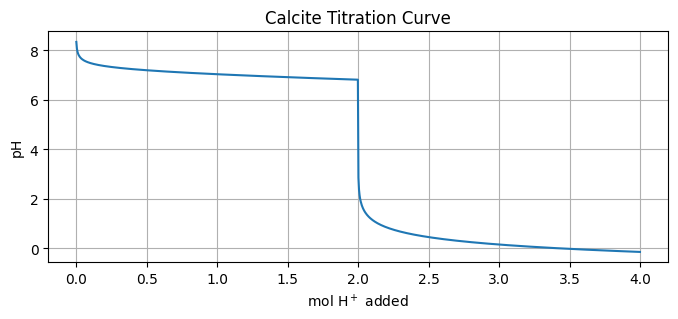

In [7]:
# Plot
plt.figure(figsize=(8, 3))
plt.plot(hcl, results_df["pH"])
plt.xlabel("mol H$^+$ added")
plt.ylabel("pH")
plt.title("Calcite Titration Curve")
plt.grid(True)
plt.show()